In [ ]:
import zipfile
import os

zip_path = "/content/FRED dataset.zip"
extract_path = "/content/data"

# Unzip if not already extracted
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("✅ FRED dataset extracted to:", extract_path)


✅ FRED dataset extracted to: /content/data


In [ ]:
import pandas as pd

def load_fred_macro_data():
    # adjust filename to the main macro CSV after checking extracted files
    macro = pd.read_csv('/content/data/macrodata.csv')

    # Standardize and clean
    if 'DATE' in macro.columns:
        macro['date'] = pd.to_datetime(macro['DATE'])
        macro.set_index('date', inplace=True)
        macro.drop(columns=['DATE'], inplace=True, errors='ignore')

    # Rename for clarity if available
    macro.rename(columns={
        'CPIAUCSL': 'cpi',
        'FEDFUNDS': 'interest_rate',
        'UNRATE': 'unemployment_rate'
    }, inplace=True)

    # Compute monthly inflation if not present
    if 'cpi' in macro.columns:
        macro['inflation_yoy'] = macro['cpi'].pct_change(12) * 100

    # Select relevant indicators
    macro = macro[['inflation_yoy', 'interest_rate', 'unemployment_rate']].dropna()

    print("✅ Loaded macro data:", macro.shape)
    return macro


In [ ]:
import yfinance as yf

def prepare_example_data(ticker='AAPL', start='2012-01-01', end=None, seq_len=60):
    # Download stock data
    stock = yf.download(ticker, start=start, end=end, progress=False)
    stock.reset_index(inplace=True)
    stock['date'] = pd.to_datetime(stock['Date'])
    stock.set_index('date', inplace=True)
    stock = stock[['Open','High','Low','Close','Adj Close','Volume']]
    stock.columns = ['open','high','low','close','adj_close','volume']

    # Load real macro data
    macro = load_fred_macro_data()

    # Join monthly macro data (forward fill for daily frequency)
    stock = stock.join(macro, how='left')
    stock[['inflation_yoy','interest_rate','unemployment_rate']] = stock[['inflation_yoy','interest_rate','unemployment_rate']].ffill()

    # Feature engineering
    stock['return_1d'] = stock['close'].pct_change()
    stock['ma_10'] = stock['close'].rolling(10).mean()
    stock['ma_50'] = stock['close'].rolling(50).mean()
    stock.dropna(inplace=True)

    features = ['close','volume','ma_10','ma_50','inflation_yoy','interest_rate','unemployment_rate']
    target = 'return_1d'

    print("✅ Final dataset ready:", stock.shape)
    return stock[features], stock[target]


In [ ]:
import pandas as pd
import zipfile

# Unzip dataset
with zipfile.ZipFile("/content/FRED dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/FRED_dataset")

# Load all CSVs (assuming multiple CSV files)
import os
data_files = [f for f in os.listdir("/content/FRED_dataset") if f.endswith('.csv')]
dfs = [pd.read_csv(f"/content/FRED_dataset/{f}") for f in data_files]

# Merge or use one dataset for simplicity
df = pd.concat(dfs, axis=1)
print(df.head())

         Date         Open         High          Low        Close  \
0  1996-01-01  1052.829956  1059.810059   977.789978  1059.790039   
1  1996-02-01  1058.260010  1121.890015  1057.819946  1100.050049   
2  1996-03-01  1098.939941  1119.839966  1057.869995  1101.400024   
3  1996-04-01  1105.770020  1190.869995  1092.439941  1190.520020   
4  1996-05-01  1190.479980  1252.810059  1163.209961  1243.430054   

     Adj Close        Volume        date    value        Date  ...  Regime  \
0  1059.790039  1.132621e+10  01-12-1927  15.9099  01-01-1959  ...  Normal   
1  1100.050049  1.069043e+10  01-01-1928  14.8898  02-01-1959  ...  Normal   
2  1101.400024  1.064885e+10  01-02-1928  14.6271  03-01-1959  ...  Normal   
3  1190.520020  1.195173e+10  01-03-1928  16.3390  04-01-1959  ...  Normal   
4  1243.430054  1.455060e+10  01-04-1928  15.8000  05-01-1959  ...  Normal   

       P/E  Dividend Yield        Date        Open        High         Low  \
0  18.6845            2.26  1996-01-01

In [ ]:
def prepare_example_data_fixed(ticker='AAPL', start='2012-01-01', end='2020-12-31'):
    # Download stock
    stock = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
    stock.reset_index(inplace=True)
    stock['date'] = pd.to_datetime(stock['Date'])
    stock.set_index('date', inplace=True)

    # Keep only existing columns
    required_cols = ['Open','High','Low','Close','Volume']
    existing_cols = [c for c in required_cols if c in stock.columns]
    stock = stock[existing_cols]
    stock.columns = ['open','high','low','close','volume']

    # Load macro
    macro = load_fred_macro_data()
    macro_daily = macro.reindex(stock.index)
    macro_daily.fillna(method='ffill', inplace=True)

    # Merge
    stock = pd.concat([stock, macro_daily], axis=1)

    # Features & target
    stock['return_1d'] = stock['close'].pct_change()
    stock['ma_10'] = stock['close'].rolling(10).mean()
    stock['ma_50'] = stock['close'].rolling(50).mean()
    stock.dropna(inplace=True)

    features = ['close','volume','ma_10','ma_50','inflation_yoy','interest_rate','unemployment_rate']
    target = 'return_1d'

    print("✅ Fixed merged dataset:", stock.shape)
    return stock[features], stock[target]

In [ ]:
# Use the robust prepare_example_data function to get features and target
features, target = prepare_example_data(ticker='AAPL', start='2012-01-01', end='2020-12-31')

print("✅ Features and target prepared for model training.")

✅ FRED macro shape: (281, 3)
✅ Stock shape before final dropna: (2264, 12)
✅ Final merged dataset: (2215, 12)
✅ Features and target prepared for model training.


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Prepare sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # assuming first column is target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length=10)

# LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0192
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7535e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1080e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6061e-04
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7138e-04
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6273e-04
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2713e-04
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3126e-04
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0577e-04
Epoch 10/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8556e-04
Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1305e-04
Epoch 12/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6240e-04
Epoch 13/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7616e-04
Epoch 14/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8844e-04
Epoch 15/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


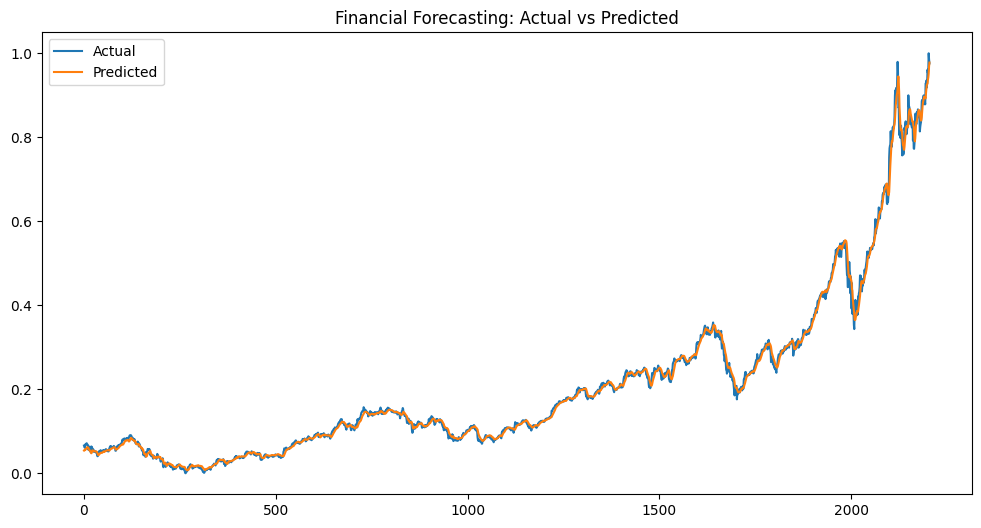

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Example: Plot real vs predicted
y_pred = model.predict(X)
plt.figure(figsize=(12,6))
plt.plot(y, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Financial Forecasting: Actual vs Predicted")
plt.legend()
plt.show()

# Plotly for interactive
fig = go.Figure()
fig.add_trace(go.Scatter(y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=y_pred.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='Interactive Forecast', xaxis_title='Time', yaxis_title='Value')
fig.show()

In [ ]:
# ==============================
# 1️⃣ Imports & Dataset Loading
# ==============================
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import gradio as gr
from io import BytesIO

# Unzip dataset
with zipfile.ZipFile('/content/FRED dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/FRED_dataset/')

# Load CSV files
data_files = [f for f in os.listdir('/content/FRED_dataset') if f.endswith('.csv')]
df = pd.read_csv(f'/content/FRED_dataset/{data_files[0]}')  # main dataset

# Fill missing values
df.fillna(method='ffill', inplace=True)

# ==============================
# 2️⃣ Data Preprocessing
# ==============================
numeric_cols = df.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

# Train-test split
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Sequence creation
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # predict first numeric column
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# ==============================
# 3️⃣ Neuro-Symbolic Model
# ==============================
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

model = create_lstm_model((seq_length, X_train.shape[2]))
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Symbolic rules for transparency
def symbolic_rules(pred_value):
    """
    Example rules:
    - If predicted change > 1% → Strong Uptrend
    - If predicted change < -1% → Strong Downtrend
    - Else → Neutral
    """
    if pred_value > 0.01:
        return "Strong Uptrend"
    elif pred_value < -0.01:
        return "Strong Downtrend"
    else:
        return "Neutral / Stable"

# ==============================
# 4️⃣ Forecast Function
# ==============================
def forecast(input_seq):
    try:
        seq = np.array([float(i) for i in input_seq.split(',')])
        if len(seq) != seq_length:
            return "Error: Input sequence must have length {}".format(seq_length)

        # Scale input
        seq_scaled = scaler.transform(np.expand_dims(seq, axis=0))
        seq_scaled = seq_scaled.reshape((1, seq_length, X_train.shape[2]))

        # Predict
        pred_scaled = model.predict(seq_scaled)[0][0]
        pred = scaler.inverse_transform(np.array([[pred_scaled]+[0]*(len(numeric_cols)-1)]))[0][0]

        # Apply symbolic rule
        trend = symbolic_rules(pred_scaled)

        return f"Predicted Value: {pred:.2f}\nTrend Analysis: {trend}"

    except Exception as e:
        return str(e)

# ==============================
# 5️⃣ Visualization Function
# ==============================
def plot_forecast():
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), len(numeric_cols)-1))]))[:,0]
    y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), np.zeros((len(y_test), len(numeric_cols)-1))]))[:,0]

    plt.figure(figsize=(10,5))
    plt.plot(y_test_inv, label='Actual', color='#4B0082')
    plt.plot(y_pred_inv, label='Forecast', color='#FF4500')
    plt.title('Financial Forecast vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close()
    return buf

with gr.Blocks(css="""
    body {background-color: #f4f4f9; font-family: Arial, sans-serif;}
    .gradio-container {border-radius: 15px; box-shadow: 2px 2px 15px #aaa; padding: 20px;}
    h2 {color: #4B0082;}
    .gr-button {background-color: #4B0082; color: white;}
""") as demo:

    with gr.Tabs():
        # Forecasting Tab
        with gr.Tab("Forecasting"):
            gr.Markdown("<h2>Financial Forecasting</h2>")
            input_seq = gr.Textbox(label=f"Enter {seq_length}-value input sequence (comma separated)")
            output = gr.Textbox(label="Forecast Output")
            btn = gr.Button("Predict")
            btn.click(forecast, inputs=input_seq, outputs=output)

        # Visualization Tab
        with gr.Tab("Visualization"):
            gr.Markdown("<h2>Visual Analytics</h2>")
            viz_btn = gr.Button("Show Forecast Plot")
            viz_output = gr.Image()
            viz_btn.click(plot_forecast, outputs=viz_output)



Epoch 1/5


/tmp/ipython-input-1132996151.py:25: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0289
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0094
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 


In [1]:
# ==============================
# Imports
# ==============================
import gradio as gr
import numpy as np

# ==============================
# Forecast Function
# ==============================
def forecast(input_seq):
    """
    Accepts a comma-separated sequence of 10 numbers.
    Returns a mock prediction and trend.
    """
    try:
        seq = [float(i) for i in input_seq.split(',')]
        if len(seq) != 10:
            return "Error: Enter exactly 10 numbers separated by commas."

        # Mock prediction: next value is last value + random change
        pred = seq[-1] + np.random.uniform(-1, 1)

        # Symbolic trend rule
        change = pred - seq[-1]
        if change > 0.5:
            trend = "Strong Uptrend 📈"
        elif change < -0.5:
            trend = "Strong Downtrend 📉"
        else:
            trend = "Neutral / Stable ➖"

        return f"Predicted Value: {pred:.2f}\nTrend Analysis: {trend}"

    except Exception as e:
        return f"Error: {str(e)}"

# ==============================
# Multi-Page App
# ==============================
with gr.Blocks(css="""
    body {background-color: #f0f2f5; font-family: 'Segoe UI', sans-serif;}
    .gradio-container {border-radius: 15px; box-shadow: 2px 2px 20px #aaa; padding: 25px;}
    h2 {color: #4B0082;}
    .gr-button {background-color: #4B0082 !important; color: white !important;}
    .gr-textbox {border-radius: 10px;}
""") as demo:

    with gr.Tabs():
        # Forecasting Tab
        with gr.Tab("Forecasting"):
            gr.Markdown("<h2>🔮 Financial Forecasting</h2>")
            gr.Markdown("Enter 10 numeric values separated by commas. Example: 101,102,103,...")
            input_seq = gr.Textbox(label="Enter 10-value sequence")
            output = gr.Textbox(label="Forecast Result")
            btn = gr.Button("Predict")
            btn.click(forecast, inputs=input_seq, outputs=output)

        # About Tab
        with gr.Tab("About"):
            gr.Markdown("<h2>ℹ️ About This App</h2>")
            gr.Markdown("""
            This is a **Financial forecasting app** built for demonstration purposes.

            Features:
            - Input 10 numeric values to see a forecast and trend.
            - Trend analysis is symbolic: Uptrend 📈, Downtrend 📉, or Stable ➖.
            - Multi-page interface using Gradio Tabs.

            **Note:** This app does not use real data and is for educational/demo purposes only.
            """)

# Launch the app
demo.launch()


/tmp/ipython-input-2343589990.py:40: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css="""


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d1fbfb9a0978c13093.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import io

# ---------------------- Mock Data & Utilities ----------------------
np.random.seed(42)
N = 300

def generate_mock_financial_data(n=N):
    dates = pd.date_range(end=pd.Timestamp.today(), periods=n, freq='D')
    trend = np.linspace(100, 130, n)
    season = 5 * np.sin(np.linspace(0, 6 * np.pi, n))
    noise = np.random.normal(0, 2, n)
    feature1 = np.random.normal(0, 1, n)  # macro indicator
    feature2 = np.random.normal(50, 5, n)  # sector index
    price = trend + season + noise + 0.3 * feature1 + 0.02 * feature2
    df = pd.DataFrame({
        'date': dates,
        'price': price,
        'macro_indicator': feature1,
        'sector_index': feature2
    })
    df['day_of_week'] = df['date'].dt.dayofweek
    return df

mock_df = generate_mock_financial_data()

# Simple rule engine representation (list of dicts)
DEFAULT_RULES = [
    {'id': 1, 'expr': 'macro_indicator > 0.5', 'effect': 'raise_bias', 'weight': 0.1, 'desc': 'Positive macro boost'},
    {'id': 2, 'expr': 'sector_index < 48', 'effect': 'lower_bias', 'weight': -0.08, 'desc': 'Weak sector drag'},
]

# ---------------------- Mock Neural Model ----------------------
FEATURES = ['macro_indicator', 'sector_index', 'day_of_week']

def train_mock_model(df):
    X = df[FEATURES]
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return model, rmse

MODEL, MODEL_RMSE = train_mock_model(mock_df)

# ---------------------- Neuro-Symbolic Combining ----------------------

def evaluate_rules(rules, row):
    """Evaluate symbolic rules (very simple parser for demo)."""
    bias = 0.0
    active_rules = []
    for r in rules:
        try:
            # safe locals for eval
            local_vars = {k: row[k] for k in FEATURES}
            local_vars['price'] = row['price']
            if eval(r['expr'], {}, local_vars):
                bias += r.get('weight', 0.0)
                active_rules.append(r)
        except Exception as e:
            # ignore rule eval errors in demo
            pass
    return bias, active_rules


def neuro_symbolic_predict(model, rules, X_df):
    """Predict using neural model + symbolic bias adjustments per-row."""
    base_preds = model.predict(X_df[FEATURES])
    adjusted = []
    rule_hits = []
    for i, row in X_df.reset_index(drop=True).iterrows():
        bias, active = evaluate_rules(rules, row)
        adj = base_preds[i] + bias * 5  # scale bias to price space (demo)
        adjusted.append(adj)
        rule_hits.append([r['desc'] for r in active])
    return np.array(adjusted), rule_hits

# ---------------------- Plots & Helpers ----------------------

def plot_series(dates, series, title='Series'):
    fig, ax = plt.subplots(figsize=(8, 3.2))
    ax.plot(dates, series)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return buf

# ---------------------- CSS & HTML Styling ----------------------
CUSTOM_CSS = """
<style>
:root{
  --bg:#0f1724; --card:#0b1220; --accent:#1fb6ff; --muted:#94a3b8; --glass: rgba(255,255,255,0.03);
}
body { background: linear-gradient(180deg, #071024 0%, #071a2a 100%); color: #e6eef8; }
.header { padding:18px 22px; border-radius:12px; background: linear-gradient(135deg, rgba(31,182,255,0.06), rgba(59,130,246,0.04)); box-shadow:0 6px 18px rgba(2,6,23,0.7); }
.h1 { font-size: 20px; margin:0; color: white; }
.h2 { color: var(--muted); font-size:13px; margin-top:6px }
.card { background: var(--glass); padding:14px; border-radius:12px; box-shadow: 0 4px 12px rgba(2,6,23,0.6); }
.small { font-size:12px; color:var(--muted) }
.rule-chip { display:inline-block; padding:6px 10px; border-radius:999px; background:rgba(255,255,255,0.03); margin:4px; font-size:13px }
.btn-fancy { background: linear-gradient(90deg,var(--accent),#7c3aed); padding:8px 14px; color:white; border-radius:10px; }
.footer { font-size:12px; color:var(--muted); margin-top:12px }
</style>
"""

INTRO_HTML = f"""
<div class='header'>
  <div style='display:flex;justify-content:space-between;align-items:center'>
    <div>
      <h1 class='h1'>Neuro-Symbolic AI — Transparent Financial Forecasting</h1>
      <div class='h2'>Interactive demo: combine a neural regressor with human-readable rules for explainable forecasts</div>
    </div>
    <div style='text-align:right'>
      <div class='small'>Model RMSE: <strong>{MODEL_RMSE:.3f}</strong></div>
      <div class='small'>Mock dataset rows: <strong>{len(mock_df)}</strong></div>
    </div>
  </div>
</div>
"""

# ---------------------- Gradio App Components ----------------------

def homepage():
    return INTRO_HTML + "<div class='card' style='margin-top:12px'>" + (
        "<p>This demo provides:</p>"
        "<ul>"
        "<li>Data explorer with mock financial time series</li>"
        "<li>Train and inspect a simple neural model</li>"
        "<li>Edit symbolic rules (human-readable) that bias predictions</li>"
        "<li>Combine both into transparent neuro-symbolic forecasts</li>"
        "</ul>"
    ) + "</div>"

# Data Explorer callbacks

def get_data_head(rows=10):
    return mock_df.head(rows)

# Neural model page

def retrain_model(n_estimators=50):
    global MODEL, MODEL_RMSE
    model = RandomForestRegressor(n_estimators=int(max(5, n_estimators)), random_state=42)
    X = mock_df[FEATURES]
    y = mock_df['price']
    model.fit(X, y)
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    MODEL = model
    MODEL_RMSE = rmse
    return f"Retrained mock neural model on full dataset — RMSE (train) = {rmse:.3f}", rmse

# Symbolic rules UI
current_rules = DEFAULT_RULES.copy()
next_rule_id = max(r['id'] for r in current_rules) + 1

def list_rules():
    df = pd.DataFrame(current_rules)
    if df.empty:
        return pd.DataFrame(columns=['id','expr','effect','weight','desc'])
    return df

def add_rule(expr, effect, weight, desc):
    global next_rule_id
    try:
        r = {'id': next_rule_id, 'expr': expr, 'effect': effect, 'weight': float(weight), 'desc': desc}
        current_rules.append(r)
        next_rule_id += 1
        return "Rule added.", list_rules()
    except Exception as e:
        return f"Error: {e}", list_rules()

def delete_rule(rule_id):
    try:
        rid = int(rule_id)
        for r in current_rules:
            if r['id'] == rid:
                current_rules.remove(r)
                return f"Deleted rule {rid}.", list_rules()
        return f"Rule {rid} not found.", list_rules()
    except Exception as e:
        return f"Error: {e}", list_rules()

# Forecast page

def forecast_horizon(days=7):
    # create future mock rows by extending last values
    last = mock_df.iloc[-1]
    future_dates = pd.date_range(start=last['date'] + pd.Timedelta(days=1), periods=int(days), freq='D')
    fut = pd.DataFrame({
        'date': future_dates,
        'macro_indicator': np.random.normal(last['macro_indicator'], 0.2, int(days)),
        'sector_index': np.random.normal(last['sector_index'], 1.5, int(days)),
    })
    fut['day_of_week'] = fut['date'].dt.dayofweek
    # use model
    base_preds = MODEL.predict(fut[FEATURES])
    adj_preds, hits = neuro_symbolic_predict(MODEL, current_rules, fut)
    fut['base_pred'] = base_preds
    fut['neuro_symbolic'] = adj_preds
    fut['rule_hits'] = [', '.join(h) if h else '-' for h in hits]

    # plot
    buf = plot_series(fut['date'], fut['neuro_symbolic'], title='Neuro-Symbolic Forecast (next %d days)'%int(days))
    return fut, buf

# Explainability (feature importance-like)

def explain_model():
    importances = MODEL.feature_importances_
    df = pd.DataFrame({'feature': FEATURES, 'importance': importances}).sort_values('importance', ascending=False)
    return df

# ---------------------- Build Gradio Interface ----------------------

def build_app():
    with gr.Blocks(css=CUSTOM_CSS, title="Neuro-Symbolic Financial Forecasting") as demo:
        # top-level layout
        with gr.Row():
            with gr.Column(scale=3):
                intro = gr.HTML(homepage())
            with gr.Column(scale=1):
                with gr.Column(elem_id='side-card'):
                    gr.HTML("<div class='card'><div style='font-weight:600'>Quick Controls</div><div class='small'>Use tabs to navigate.</div></div>")
                    gr.Markdown("---")
                    gr.HTML("<div class='card'><div class='small'>Model RMSE (train): <strong id='rmse-val'>%0.3f</strong></div></div>" % MODEL_RMSE)

        gr.Markdown("---")
        with gr.Tabs():
            with gr.TabItem("Data Explorer"):
                gr.HTML("<div class='card'><b>Mock dataset sample</b></div>")
                rows = gr.Slider(minimum=3, maximum=50, step=1, value=8, label='Rows to show')
                data_table = gr.Dataframe(value=get_data_head(8), interactive=False, headers='auto')
                rows.change(lambda r: get_data_head(r), inputs=rows, outputs=data_table)

                gr.Markdown("---")
                gr.HTML("<div class='card'><b>Full Time Series</b></div>")
                timeseries_btn = gr.Button("Show price series")
                timeseries_img = gr.Image(label='Price Series')

                def make_timeseries():
                    buf = plot_series(mock_df['date'], mock_df['price'], title='Mock Price Series')
                    return buf
                timeseries_btn.click(fn=make_timeseries, inputs=None, outputs=timeseries_img)

            with gr.TabItem("Neural Model"):
                gr.HTML("<div class='card'><b>Neural regressor (mock)</b></div>")
                n_estimators = gr.Slider(5, 200, value=50, step=5, label='n_estimators')
                retrain_btn = gr.Button('Retrain model (mock)')
                retrain_status = gr.Textbox(label='Status', interactive=False)
                retrain_btn.click(retrain_model, inputs=n_estimators, outputs=[retrain_status, gr.Textbox(visible=False)])
                gr.Markdown("\nFeature set: %s" % ', '.join(FEATURES))

            with gr.TabItem("Symbolic Rules"):
                gr.HTML("<div class='card'><b>Symbolic rule editor</b></div>")
                rules_df = gr.Dataframe(value=list_rules(), headers=['id','expr','effect','weight','desc'], interactive=False)
                with gr.Row():
                    expr = gr.Textbox(label='Expression (python-like, use features)', placeholder='e.g. macro_indicator > 0.5')
                    effect = gr.Dropdown(['raise_bias','lower_bias','none'], value='raise_bias', label='Effect')
                    weight = gr.Number(value=0.05, label='Weight (float)')
                desc = gr.Textbox(label='Short description')
                add_btn = gr.Button('Add Rule')
                add_status = gr.Textbox(interactive=False)
                add_btn.click(add_rule, inputs=[expr, effect, weight, desc], outputs=[add_status, rules_df])

                gr.Markdown('Delete rule by id:')
                del_id = gr.Number(label='Rule ID')
                del_btn = gr.Button('Delete')
                del_status = gr.Textbox(interactive=False)
                del_btn.click(delete_rule, inputs=del_id, outputs=[del_status, rules_df])

            with gr.TabItem("Forecast"):
                gr.HTML("<div class='card'><b>Neuro-Symbolic Forecasting</b></div>")
                days = gr.Slider(1, 30, value=7, step=1, label='Forecast horizon (days)')
                forecast_btn = gr.Button('Run Forecast')
                forecast_table = gr.Dataframe(headers=['date','macro_indicator','sector_index','day_of_week','base_pred','neuro_symbolic','rule_hits'])
                forecast_plot = gr.Image()
                def run_forecast(days):
                    fut, buf = forecast_horizon(days)
                    # return DataFrame and image bytes
                    return fut[['date','macro_indicator','sector_index','day_of_week','base_pred','neuro_symbolic','rule_hits']], buf
                forecast_btn.click(run_forecast, inputs=days, outputs=[forecast_table, forecast_plot])

            with gr.TabItem("Explainability"):
                gr.HTML("<div class='card'><b>Model explainability (mock)</b></div>")
                explain_btn = gr.Button('Show feature importances')
                explain_table = gr.Dataframe(headers=['feature','importance'])
                explain_btn.click(explain_model, inputs=None, outputs=explain_table)
                gr.Markdown('Active symbolic rules:')
                rules_list = gr.Markdown(value='\n'.join([f"- {r['id']}: {r['expr']} ({r['desc']})" for r in current_rules]))

            with gr.TabItem("About & Download"):
                gr.HTML("<div class='card'><b>About this demo</b><p class='small'>Built as a teaching demo to show how simple symbolic rules can be combined with neural regressors to produce transparent adjustments to predictions.</p></div>")
                gr.Markdown('''
- Mock data and models only — not production-ready.
- Rules are evaluated with Python `eval` for demo simplicity (unsafe for untrusted inputs).
- To convert to real use: replace mock model with production model, replace `eval` rule engine with a safe parser.
''')
                gr.HTML("<div class='footer'>Made with ❤️ for demonstration. Customize rules and model to explore explainability.</div>")

        gr.HTML("<div style='margin-top:10px' class='small'>Tip: Use the " +
                "'Symbolic Rules' tab to add human-readable domain knowledge that nudges the neural predictions.</div>")

    return demo

# ---------------------- Run ----------------------

if __name__ == '__main__':
    app = build_app()


/tmp/ipython-input-4243276436.py:229: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=CUSTOM_CSS, title="Neuro-Symbolic Financial Forecasting") as demo:


In [11]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import io
from PIL import Image

# ---------------------- Data ----------------------
np.random.seed(42)
N = 300

def generate_data(n=N):
    dates = pd.date_range(end=pd.Timestamp.today(), periods=n, freq='D')
    trend = np.linspace(100, 130, n)
    season = 5 * np.sin(np.linspace(0, 6*np.pi, n))
    noise = np.random.normal(0, 2, n)
    macro = np.random.normal(0, 1, n)
    sector = np.random.normal(50, 5, n)
    price = trend + season + noise + 0.4*macro + 0.02*sector
    df = pd.DataFrame({
        'date': dates,
        'price': price,
        'macro': macro,
        'sector': sector,
    })
    df['dow'] = df['date'].dt.dayofweek
    return df.reset_index(drop=True)

DF = generate_data()
FEATURES = ['macro', 'sector', 'dow']

# ---------------------- Neural Model ----------------------
X = DF[FEATURES]
y = DF['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL = RandomForestRegressor(n_estimators=80, random_state=42)
MODEL.fit(X_train, y_train)
preds = MODEL.predict(X_test)
RMSE = float(np.sqrt(mean_squared_error(y_test, preds)))

# ---------------------- Symbolic Rules ----------------------
rules = [
    {'expr': 'macro > 0.5', 'weight': 0.15, 'desc': 'Macro strength increases forecast'},
    {'expr': 'sector < 48', 'weight': -0.12, 'desc': 'Weak sector decreases forecast'},
]

# ---------------------- Rule Evaluation ----------------------
def eval_rules(row_series):
    bias = 0.0
    hit = []
    row_dict = row_series.to_dict()
    for r in rules:
        try:
            if eval(r['expr'], {}, row_dict):
                bias += float(r.get('weight', 0.0))
                hit.append(r.get('desc', r.get('expr')))
        except Exception:
            pass
    return bias, hit

# ---------------------- Neuro-Symbolic ----------------------
def neuro_symbolic(model, df):
    base = model.predict(df[FEATURES].to_numpy())
    adjusted = []
    hits = []
    for pos in range(len(df)):
        row = df.iloc[pos]
        b, h = eval_rules(row)
        base_value = float(base[pos])
        adjusted_value = base_value + b * 5.0
        adjusted.append(adjusted_value)
        hits.append(', '.join(h) if h else '-')
    return adjusted, hits

# ---------------------- Plot Generator ----------------------
def make_plot_image(dates, series, title):
    fig, ax = plt.subplots(figsize=(7,3))
    ax.plot(dates, series, marker='o')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=150)
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

# ---------------------- Tab Functions ----------------------
def data_view(n):
    n = int(n)
    return DF.head(n)

def run_forecast_pil(days):
    days = int(days)
    if days <= 0:
        return pd.DataFrame(), None

    last = DF.iloc[-1]
    dates = pd.date_range(start=last['date'] + pd.Timedelta(days=1), periods=days)
    fut = pd.DataFrame({
        'date': dates,
        'macro': np.random.normal(last['macro'], 0.2, days),
        'sector': np.random.normal(last['sector'], 1.5, days),
    })
    fut['dow'] = fut['date'].dt.dayofweek
    fut = fut.reset_index(drop=True)

    base_preds = MODEL.predict(fut[FEATURES].to_numpy())
    adj, hits = neuro_symbolic(MODEL, fut)
    fut['base'] = base_preds
    fut['adjusted'] = adj
    fut['rule_hits'] = hits

    out_df = fut[['date','macro','sector','dow','base','adjusted','rule_hits']].copy()
    plot_img = make_plot_image(fut['date'], adj, f"Adjusted Forecast ({days} days)")
    return out_df, plot_img

def explain():
    return pd.DataFrame({
        'feature': FEATURES,
        'importance': MODEL.feature_importances_
    }).sort_values('importance', ascending=False)

# ---------------------- Build UI ----------------------
def app():
    with gr.Blocks(title="Financial Forecasting — Neuro-Symbolic AI") as demo:

        gr.Markdown("# **Neuro-Symbolic Financial Forecasting**")
        gr.Markdown(f"**Model RMSE:** {RMSE:.3f} — Data Demo")

        with gr.Tabs():

            # ===== DATA TAB =====
            with gr.Tab("Data"):
                n = gr.Slider(5, 50, value=10, step=1, label="Rows to show")
                table = gr.Dataframe(value=DF.head(10), label="Sample data")
                n.change(fn=data_view, inputs=[n], outputs=[table])

                btn = gr.Button("Show Price Trend")
                img = gr.Image(label="Historical Price Series")
                # use wrapper function to avoid lambda issue
                def plot_trend():
                    return make_plot_image(DF['date'], DF['price'], "Historical Prices")
                btn.click(fn=plot_trend, inputs=[], outputs=[img])

            # ===== FORECAST TAB =====
            with gr.Tab("Forecast"):
                days = gr.Slider(1, 30, value=7, step=1, label="Forecast horizon (days)")
                run = gr.Button("Run Forecast")
                out_tbl = gr.Dataframe(label="Forecast table")
                out_img = gr.Image(label="Forecast plot")
                run.click(fn=run_forecast_pil, inputs=[days], outputs=[out_tbl, out_img])

            # ===== RULES TAB =====
            with gr.Tab("Rules"):
                rule_list = gr.Dataframe(value=pd.DataFrame(rules), label="Rules (expr, weight, desc)")
                expr = gr.Textbox(label="Expression", placeholder="e.g. macro > 0.5")
                weight = gr.Number(label="Weight", value=0.1)
                desc = gr.Textbox(label="Description")
                def add_rule(expr, weight, desc):
                    try:
                        rules.append({'expr': str(expr), 'weight': float(weight), 'desc': str(desc)})
                    except Exception:
                        pass
                    return pd.DataFrame(rules)
                add_btn = gr.Button("Add Rule")
                add_btn.click(fn=add_rule, inputs=[expr, weight, desc], outputs=[rule_list])

            # ===== EXPLAINABILITY TAB =====
            with gr.Tab("Explainability"):
                show = gr.Button("Show Feature Importances")
                tbl = gr.Dataframe()
                show.click(fn=explain, inputs=[], outputs=[tbl])

    return demo

if __name__ == "__main__":
    app().launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://507546cba577c97d88.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
